# ADS 509 Module 1: APIs and Web Scraping

This notebook has two parts. In the first part, you will scrape lyrics from AZLyrics.com. In the second part, you'll run code that verifies the completeness of your data pull. 

For this assignment you have chosen two musical artists who have at least 20 songs with lyrics on AZLyrics.com. We start with pulling some information and analyzing them.


--- Starting Lyrics Scraping and Analysis ---

Processing taylor_swift...
    Waiting 4.05s before requesting https://www.azlyrics.com/t/taylorswift.html...
Found 468 unique song links for taylor_swift.

Processing ed_sheeran...
    Waiting 3.35s before requesting https://www.azlyrics.com/e/edsheeran.html...
Found 281 unique song links for ed_sheeran.
 -> Sufficient songs found for taylor_swift (468 songs).
 -> Sufficient songs found for ed_sheeran (281 songs).

Preparing lyrics folder ('lyrics')...
Removing existing directory: lyrics
Directory created.

Scraping lyrics for selected songs...

Starting scrape for taylor_swift (max 25 songs)...
  Processing (1/25): https://www.azlyrics.com/lyrics/taylorswift/canigowithyou.html
    Waiting 4.62s before requesting https://www.azlyrics.com/lyrics/taylorswift/canigowithyou.html...
    -> Saved lyrics for '"Can I Go With You" lyrics' to taylorswift_canigowithyou.txt
  Processing (2/25): https://www.azlyrics.com/lyrics/taylorswift/iknewyouwere

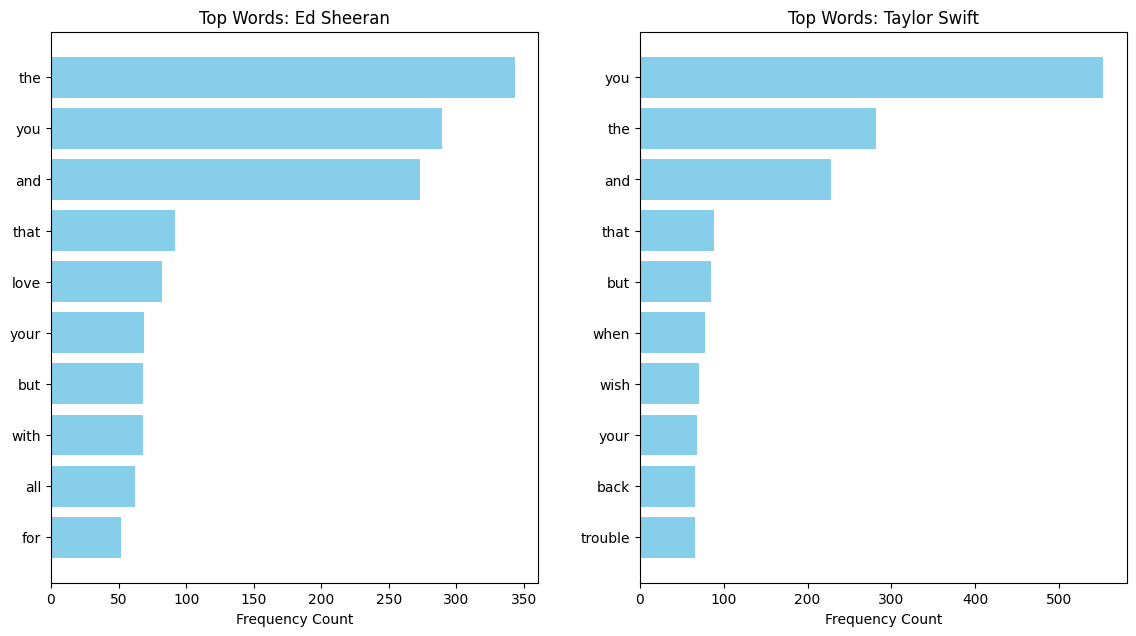

In [ ]:
# Import necessary libraries
import os
import re
import time
import random
import shutil
import requests
from bs4 import BeautifulSoup
from collections import defaultdict, Counter
import sys # For potential error exit

# --- Configuration ---
# Define the artists to scrape - choose two artists with at least 20 songs each
# You can change these artists or add more following the format 'internal_name': 'azlyrics_artist_page_url'
ARTISTS = {
    'taylor_swift': "https://www.azlyrics.com/t/taylorswift.html",
    'ed_sheeran': "https://www.azlyrics.com/e/edsheeran.html"
    # 'another_artist': "https://www.azlyrics.com/a/anotherartist.html"
}

# Maximum number of songs to scrape per artist (to manage runtime)
MAX_SONGS_PER_ARTIST = 25

# Base directory to store lyrics
LYRICS_DIR = "lyrics"

# Politeness delay (seconds) between requests to avoid overloading the server
BASE_DELAY = 3
RANDOM_DELAY = 2

# --- Helper Functions ---

def generate_filename_from_link(link):
    """Generates a safe filename from an AZLyrics URL."""
    if not link:
        return None
    # Drop the schema and domain, remove .html
    name = link.replace("https://", "").replace("http://", "")
    name = name.replace("www.azlyrics.com/lyrics/", "")
    name = name.replace(".html", "")
    # Replace special characters with underscore
    name = re.sub(r'[^a-zA-Z0-9]+', '_', name)
    # Ensure it doesn't start/end with underscore
    name = name.strip('_')
    # Add .txt extension
    name = name + ".txt"
    return name

def words(text):
    """Extracts lowercase words from a text string."""
    return re.findall(r'\b\w+\b', text.lower()) # Use word boundaries for better tokenization

def polite_request(url):
    """Makes a request to a URL with a polite delay."""
    delay = BASE_DELAY + RANDOM_DELAY * random.random()
    print(f"    Waiting {delay:.2f}s before requesting {url}...")
    time.sleep(delay)
    try:
        response = requests.get(url, timeout=15) # Added timeout
        response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
        return response
    except requests.exceptions.RequestException as e:
        print(f"    Error requesting {url}: {e}")
        return None

# --- Main Script Logic ---

def scrape_artist_links(artists_dict):
    """Scrapes AZLyrics artist pages to get links to individual song lyrics."""
    lyrics_pages = defaultdict(list)
    print("Collecting song links for each artist...")
    for artist, artist_page_url in artists_dict.items():
        print(f"\nProcessing {artist}...")
        response = polite_request(artist_page_url)
        if response is None:
            print(f"Skipping {artist} due to request error.")
            continue

        soup = BeautifulSoup(response.text, 'html.parser')
        # Find the div containing the list of songs, often identified by id='listAlbum'
        song_list_div = soup.find('div', {'id': 'listAlbum'})

        if song_list_div:
            links = song_list_div.find_all('a', href=True)
            count = 0
            for link in links:
                href = link['href']
                # Ensure the link points to a lyrics page and format it correctly
                if href.startswith('../lyrics/') or href.startswith('/lyrics/'):
                    full_url = 'https://www.azlyrics.com' + href.replace('..', '')
                    if full_url not in lyrics_pages[artist]: # Avoid duplicates
                         lyrics_pages[artist].append(full_url)
                         count +=1

            print(f"Found {count} unique song links for {artist}.")
        else:
            print(f"Could not find song list div ('#listAlbum') for {artist}. Scraping might fail.")

    # Verify we have enough songs for each artist found
    valid_artists = {}
    for artist, lp in lyrics_pages.items():
        if len(lp) >= 20:
             print(f" -> Sufficient songs found for {artist} ({len(lp)} songs).")
             valid_artists[artist] = lp # Keep only artists with enough songs
        else:
             print(f" -> WARNING: Not enough songs found for {artist} ({len(lp)} songs). Will skip this artist if fewer than 1 song.")

    # Remove artists with 0 songs
    lyrics_pages = {artist: links for artist, links in lyrics_pages.items() if links}

    if not lyrics_pages:
        print("\nERROR: No artists with valid song links found. Exiting.")
        sys.exit(1) # Exit if no data can be scraped

    return lyrics_pages

def scrape_and_save_lyrics(lyrics_pages_dict, base_dir):
    """Scrapes lyrics for each song and saves them to files."""
    print(f"\nPreparing lyrics folder ('{base_dir}')...")
    if os.path.exists(base_dir):
        print(f"Removing existing directory: {base_dir}")
        shutil.rmtree(base_dir)
    os.makedirs(base_dir)
    print("Directory created.")

    print("\nScraping lyrics for selected songs...")
    start_time = time.time()
    total_pages_scraped = 0

    for artist, page_urls in lyrics_pages_dict.items():
        artist_dir = os.path.join(base_dir, artist)
        if not os.path.exists(artist_dir):
            os.makedirs(artist_dir)

        print(f"\nStarting scrape for {artist} (max {MAX_SONGS_PER_ARTIST} songs)...")
        songs_scraped_for_artist = 0

        # Shuffle the list to get a random sample if MAX_SONGS_PER_ARTIST is less than total
        random.shuffle(page_urls)

        for page_url in page_urls:
            if songs_scraped_for_artist >= MAX_SONGS_PER_ARTIST:
                print(f"Reached limit of {MAX_SONGS_PER_ARTIST} songs for {artist}.")
                break

            print(f"  Processing ({songs_scraped_for_artist + 1}/{MAX_SONGS_PER_ARTIST}): {page_url}")
            response = polite_request(page_url)
            if response is None:
                print(f"    Skipping song {page_url} due to request error.")
                continue

            try:
                soup = BeautifulSoup(response.text, 'html.parser')

                # Find the title - often in a <b> tag preceding the ringtone div
                title = "Unknown Title"
                title_tag = soup.find('h1') # Titles are often in <h1> now
                if title_tag:
                     title = title_tag.get_text(strip=True).replace(' Lyrics', '') # Clean up title
                else: # Fallback to older structure check
                    title_div = soup.find('div', {'class': 'ringtone'})
                    if title_div:
                         b_tag = title_div.find_previous_sibling('b')
                         if b_tag:
                             title = b_tag.text.strip().replace('"', '')


                # Find the lyrics - often the div immediately following the ringtone/usage div
                # Look for the div without class/id that contains lyrics
                lyrics = None
                lyrics_divs = soup.find_all('div', class_=None, id=None, attrs={'style': None})
                for div in lyrics_divs:
                    # Heuristic: The lyrics div usually contains multiple <br> tags
                    if div.find_all('br') and len(div.text.strip()) > 100: # Check length too
                        lyrics = div.text.strip()
                        break # Found likely lyrics div

                if lyrics:
                    filename = generate_filename_from_link(page_url)
                    if filename:
                        filepath = os.path.join(artist_dir, filename)
                        try:
                            with open(filepath, 'w', encoding='utf-8') as f:
                                f.write(f'"{title}"\n\n{lyrics}') # Include title in file
                            print(f"    -> Saved lyrics for '{title}' to {filename}")
                            total_pages_scraped += 1
                            songs_scraped_for_artist += 1
                        except IOError as e:
                            print(f"    Error writing file {filepath}: {e}")
                    else:
                        print(f"    Could not generate valid filename for {page_url}")
                else:
                    print(f"    Could not find lyrics structure on page {page_url}")

            except Exception as e:
                print(f"    Error processing page {page_url}: {e}")

    end_time = time.time()
    print(f"\nLyrics scraping finished.")
    print(f"Total run time: {round((end_time - start_time) / 60, 2)} minutes")
    print(f"Total song pages successfully scraped: {total_pages_scraped}")
    return total_pages_scraped > 0 # Return True if any lyrics were saved

def analyze_lyrics(base_dir):
    """Analyzes the scraped lyrics files to count word frequencies."""
    print("\nAnalyzing lyrics...")
    if not os.path.isdir(base_dir):
         print(f"Error: Lyrics directory '{base_dir}' not found. Cannot analyze.")
         return None

    artist_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

    if not artist_folders:
        print("No artist subdirectories found in lyrics folder.")
        return None

    artist_word_counts = {}

    for artist in artist_folders:
        artist_path = os.path.join(base_dir, artist)
        try:
            artist_files = [f for f in os.listdir(artist_path) if f.endswith('.txt')]
            print(f"\nAnalyzing {artist} ({len(artist_files)} files found)...")

            if not artist_files:
                print("  No text files found for this artist.")
                continue

            artist_words = []
            for f_name in artist_files:
                file_path = os.path.join(artist_path, f_name)
                try:
                    with open(file_path, 'r', encoding='utf-8') as infile:
                        # Skip the first line (title) if it exists
                        lines = infile.readlines()
                        if len(lines) > 1:
                             content = "".join(lines[1:]) # Join remaining lines
                             artist_words.extend(words(content))
                        elif lines: # Handle case with only title or empty file
                             artist_words.extend(words(lines[0]))

                except FileNotFoundError:
                    print(f"  Warning: File not found during analysis: {file_path}")
                except Exception as e:
                    print(f"  Error reading file {file_path}: {e}")

            if artist_words:
                word_counts = Counter(artist_words)
                artist_word_counts[artist] = word_counts
                unique_words = len(word_counts)
                total_words = len(artist_words)
                print(f"  -> Found roughly {total_words} words, {unique_words} unique.")

                # Print the most common words (length > 2)
                print(f"  Most common words for {artist} (length > 2):")
                print("  " + "-" * 30)
                print(f"  {'Word':<15} | {'Count':<10}")
                print("  " + "-" * 30)

                # Filter common words: length > 2, ignore very common English words if desired
                common_filtered = [(w, c) for w, c in word_counts.most_common(50) if len(w) > 2]
                # Optional: add stop word filtering here if needed
                for word, count in common_filtered[:10]: # Show top 10 after filtering
                    print(f"  {word:<15} | {count:<10}")
            else:
                 print("  No words extracted for this artist.")

        except Exception as e:
            print(f"An error occurred during analysis for {artist}: {e}")

    return artist_word_counts

def create_visualizations(artist_word_counts_dict):
    """Attempts to create and save bar charts comparing word frequencies."""
    if not artist_word_counts_dict:
         print("\nNo analysis data to create visualizations.")
         return

    print("\nAttempting to create visualizations...")
    try:
        import matplotlib.pyplot as plt

        num_artists = len(artist_word_counts_dict)
        if num_artists == 0:
             print("No artist data for plotting.")
             return

        # Create a figure with subplots for each artist
        # Adjust figsize based on number of artists
        fig, axes = plt.subplots(1, num_artists, figsize=(6 * num_artists, 7), squeeze=False)
        axes = axes.flatten() # Makes indexing easier

        for i, (artist, word_counts) in enumerate(artist_word_counts_dict.items()):
            # Get the 10 most common words with length > 2
            common_words_filtered = [(word, count) for word, count in word_counts.most_common(50) if len(word) > 2][:10]

            if not common_words_filtered:
                 axes[i].text(0.5, 0.5, 'No common words found', horizontalalignment='center', verticalalignment='center')
                 axes[i].set_title(f"{artist.replace('_', ' ').title()}")
                 axes[i].axis('off') # Hide axes if no data
                 continue

            words_list, counts = zip(*common_words_filtered)

            # Plot horizontally
            y_pos = range(len(words_list))
            axes[i].barh(y_pos, counts, align='center', color='skyblue')
            axes[i].set_yticks(y_pos)
            axes[i].set_yticklabels(words_list)
            axes[i].invert_yaxis()  # labels read top-to-bottom
            axes[i].set_xlabel("Frequency Count")
            axes[i].set_title(f"Top Words: {artist.replace('_', ' ').title()}")

        plt.tight_layout(pad=3.0) # Add padding
        plot_filename = "artist_word_comparison.png"
        plt.savefig(plot_filename)
        print(f"Visualization saved as '{plot_filename}'")
        # plt.show() # Optional: uncomment to display the plot interactively

    except ImportError:
        print("\nMatplotlib library not found. Skipping visualizations.")
        print("You can install it using: pip install matplotlib")
    except Exception as e:
        print(f"\nCould not create visualizations due to an error: {e}")

def compare_word_usage(artist_word_counts_dict):
    """Prints a table comparing the usage of common words across artists."""
    if not artist_word_counts_dict or len(artist_word_counts_dict) < 2:
        print("\nNeed word counts for at least two artists to compare usage.")
        return

    print("\nComparing word usage between artists:")
    print("=" * 50)

    # Find common words across all artists (top 100 from each, length > 2)
    all_top_words = set()
    for word_counts in artist_word_counts_dict.values():
        top_words = {word for word, count in word_counts.most_common(100) if len(word) > 2}
        all_top_words.update(top_words)

    # Select some interesting words to compare (e.g., top 20 alphabetically from the common set)
    comparison_words = sorted(list(all_top_words))[:20]

    if not comparison_words:
         print("No common words (length > 2) found across artists to compare.")
         return

    artist_list = list(artist_word_counts_dict.keys())

    # Print header
    header = f"{'Word':<15}"
    for artist in artist_list:
        header += f"| {artist:<15}"
    print(header)
    print("-" * len(header))

    # Print counts for each comparison word
    for word in comparison_words:
        row = f"{word:<15}"
        for artist in artist_list:
            count = artist_word_counts_dict[artist].get(word, 0) # Get count, default to 0 if word not found
            row += f"| {count:<15}"
        print(row)

# --- Execute the Workflow ---
if __name__ == "__main__":
    print("--- Starting Lyrics Scraping and Analysis ---")

    # 1. Get Song Links
    song_links = scrape_artist_links(ARTISTS)

    # 2. Scrape and Save Lyrics (only if links were found)
    lyrics_saved = False
    if song_links:
        lyrics_saved = scrape_and_save_lyrics(song_links, LYRICS_DIR)
    else:
        print("\nSkipping lyrics scraping as no valid song links were collected.")

    # 3. Analyze Lyrics (only if lyrics were saved)
    word_analysis_results = None
    if lyrics_saved:
        word_analysis_results = analyze_lyrics(LYRICS_DIR)
    else:
        print("\nSkipping analysis as no lyrics were successfully scraped.")

    # 4. Create Visualizations (only if analysis was done)
    if word_analysis_results:
        create_visualizations(word_analysis_results)

    # 5. Compare Word Usage (only if analysis was done)
    if word_analysis_results:
        compare_word_usage(word_analysis_results)

    print("\n--- Script Finished ---")